In [4]:
from collections import namedtuple
import numpy as np
from matplotlib import pyplot as plt
import time

from read_starcd import Mesh

In [5]:
def rs(f1, f2, f, vx_, N):
    for j in range(N):
        if (vx_[j] > 0.):
            f[j, :, :] = vx_[j] * f1[j, :, :]
        else:
            f[j, :, :] = vx_[j] * f2[j, :, :]
    return f
    
def F_m(vx, vy, vz, T, n, p):
    return n * ((1. / (2. * np.pi * p.Rg * T)) ** (3. / 2.)) * (np.exp(-(vx*vx + vy*vy + vz*vz) / (2. * p.Rg * T)))

def J(f, vx, vy, vz, hv, N, p):

    n = (hv ** 3) * np.sum(f)

    ux = (1. / n) * (hv ** 3) * np.sum(vx * f)
    uy = (1. / n) * (hv ** 3) * np.sum(vy * f)
    uz = (1. / n) * (hv ** 3) * np.sum(vz * f)
    
    v2 = vx*vx + vy*vy + vz*vz
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * p.Rg)) * ((hv ** 3) * np.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz

    rho = p.m * n

    P = rho * p.Rg * T

    cx = Vx / ((2. * p.Rg * T) ** (1. / 2.))
    cy = Vy / ((2. * p.Rg * T) ** (1. / 2.))
    cz = Vz / ((2. * p.Rg * T) ** (1. / 2.))
    
    c2 = cx*cx + cy*cy + cz*cz

    Sx = (1. / n) * (hv ** 3) * np.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * np.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * np.sum(cz * c2 * f)

    mu = p.mu_0 * ((p.T_0 + p.C) / (T + p.C)) * ((T / p.T_0) ** (3. / 2.))

    f_plus = F_m(Vx, Vy, Vz, T, n, p) * (1. + (4. / 5.) * (1. - p.Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.)))

    J = (f_plus - f) * (P / mu)
    
    nu = P / mu
    
    return J, n, ux, T, nu

def solver(mesh, vmax, N, Tau, CFL, n_l, u_l, T_l, p, filename, init = '0'):
    
    # TODO add calculation of cell diameter
    h = np.min(mesh.cell_diam)
    tau = h * CFL / vmax
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    L = mesh.nc
    
    M = u_l / ((p.g * p.Rg * T_l) ** .5)
    
    n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
    u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
    T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l
    
    F_l = F_m(vx-u_l, vy, vz, T_l, n_l, p)
    F_r = F_m(vx-u_r, vy, vz, T_r, n_r, p)
    
    # initial condition 
    f = np.zeros((L, N, N, N))
    
    if (init == '0'):
        for i in range(L):
            if (mesh.cell_center_coo[i, 0] < 0.):
                f[i, :, :, :] = F_l
            else:
                f[i, :, :, :] = F_r
            
    else:
        f = np.reshape(np.loadtxt(init), (L, N, N, N))
    
    
#    for i in range(L):
#        f[i, :, :, :] = problem.set_init_cond(mesh.cell_center_coo[i])
    
    tmp = np.zeros((L, N, N, N))
    # TODO: may be join f_plus and f_minus in one array
    f_plus = np.zeros((mesh.nf, N, N, N))
    f_minus = np.zeros((mesh.nf, N, N, N))
    Flow = np.zeros((mesh.nf, N, N, N))
    RHS = np.zeros((L, N, N, N))
    
    v_nil = np.zeros((N, N, N))
    
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    Frob_norm_RHS = np.zeros(L)
    Frob_norm_iter = np.array([])
    
    t1 = time.clock()
    
    while(t < Tau*tau):
        t += tau
        # reconstruction for inner faces
        # 1st order
        for ic in range(L):
            for j in range(6):
                jf = mesh.cell_face_list[ic, j]
                # TODO: think how do this without 'if'
                if (mesh.cell_face_normal_direction[ic, j] == 1):
                    f_minus[jf, :, :, :] = f[ic, :, :, :]
                else:
                    f_plus[jf, :, :, :] = f[ic, :, :, :]
                
        # boundary condition
        # loop over all boundary faces
        for j in range(mesh.nbf):
            jf = mesh.bound_face_info[j, 0] # global face index
                # TODO: think how do this without 'if'
            if (mesh.bound_face_info[j, 1] == 2): # symmetry
                if (mesh.bound_face_info[j, 2] == 1):
                    f_plus[jf, :, :, :] = f_minus[jf, :, :, :]
                else:
                    f_minus[jf, :, :, :] = f_plus[jf, :, :, :]
            elif (mesh.bound_face_info[j, 1] == 0): # inlet
                if (mesh.bound_face_info[j, 2] == 1):
                    f_plus[jf, :, :, :] = F_l
                else:
                    f_minus[jf, :, :, :] = F_l
            elif (mesh.bound_face_info[j, 1] == 1): # outlet
                if (mesh.bound_face_info[j, 2] == 1):
                    f_plus[jf, :, :, :] = F_r
                else:
                    f_minus[jf, :, :, :] = F_r
                

        
        # riemann solver - compute fluxes
        for jf in range(mesh.nf):
            v_nil = mesh.face_normals[jf, 0] * vx + mesh.face_normals[jf, 1] * vy + mesh.face_normals[jf, 2] * vz
            Flow[jf, :, :, :] = mesh.face_areas[jf] * v_nil * np.where((v_nil < 0), f_plus[jf, :, :, :], f_minus[jf, :, :, :])
                
        
        RHS[:] = 0.
        for ic in range(L):
            for j in range(6):
                jf = mesh.cell_face_list[ic, j]
                RHS[ic, :, :, :] += - (mesh.cell_face_normal_direction[ic, j]) * (1. / mesh.cell_volumes[ic]) * Flow[jf, :, :, :]
            RHS[ic, :, :, :] += J(f[ic, :, :, :], vx, vy, vz, hv, N, p)[0]
        
            
        Frob_norm_iter = np.append(Frob_norm_iter, np.linalg.norm(RHS))


        # update values
        for ic in range(L):
            tmp[ic, :, :, :] = f[ic, :, :, :] + tau * RHS[ic, :, :, :]
                
        f = tmp
        
        
    t2 = time.clock() - t1

    t2 = int(round(t2))
    
    print "time =", t2 / 3600, "h", (t2 % 3600) / 60, "m", t2 % 60, "s"

    for ic in range(L):
        Dens[ic] = J(f[ic, :, :, :], vx, vy, vz, hv, N, p)[1]
        Vel[ic] = J(f[ic, :, :, :], vx, vy, vz, hv, N, p)[2]
        Temp[ic] = J(f[ic, :, :, :], vx, vy, vz, hv, N, p)[3]
        
    for ic in range(L):
        Frob_norm_RHS[ic] = np.linalg.norm(RHS[ic])

#    l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)
        
#    delta = l / (n_r - n_l) * np.max(Dens[1:] - Dens[:-1]) / (2 * h)

    np.savetxt(filename, np.ravel(f))
    
    Return = namedtuple('Return', ['f', 'Dens', 'Vel', 'Temp', 'Frob_norm_iter', 'Frob_norm_RHS'])
    
    S = Return(f, Dens, Vel, Temp, Frob_norm_iter, Frob_norm_RHS)
    
    return S

In [6]:
class Params(object):
 
    def __init__(self):
        #fundamental constants
        self.Na = 6.02214129e+23
        self.kB = 1.381e-23 # J / K
        #gas parameters
        self.Mol = 40e-3 # kg / mol
        self.Rg = 8.3144598  / self.Mol  # J / (kg * K) 
        self.m = self.Mol / self.Na # kg
    
        self.Pr = 2. / 3.
        self.C = 144.4
        self.T_0 = 273.11
        self.mu_0 = 2.125e-05
    
        self.g = 5. / 3.
        
        self.d = 3418e-13

p = Params()

N = 30
vmax = 2000.

Tau = 100

n_l = 2e+23 
u_l = 500.
T_l = 300.

M = u_l / ((p.g * p.Rg * T_l) ** .5)

n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l

l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)

CFL = 0.5


mesh = Mesh() 

path = './'
mesh.read_starcd(path, 3 * l)

L = mesh.nc

Number of boundary faces =  3360
Number of boundary conditions =  4
Number of cells =  1600
Number of vertices =  3362
Number of faces =  6480
sum of volumes: 3.007176881445779e-11


In [ ]:
print 'Max =', M

print 'n_l =', n_l, 'n_r =', n_r
print 'u_l =', u_l, 'u_r =', u_r
print 'T_l =', T_l, 'T_r =', T_r

hv = 2. * vmax / N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

M_l = F_m(vx-u_l, vy, vz, T_l, n_l, p)
M_r = F_m(vx-u_r, vy, vz, T_r, n_r, p)


print 'Dens'
print (J(M_l, vx, vy, vz, hv, N, p)[1] - n_l) / n_l
print (J(M_r, vx, vy, vz, hv, N, p)[1] - n_r) / n_r

print 'Vel'
print (J(M_l, vx, vy, vz, hv, N, p)[2] - u_l) / u_l
print (J(M_r, vx, vy, vz, hv, N, p)[2] - u_r) / u_r

print 'Temp'
print (J(M_l, vx, vy, vz, hv, N, p)[3] - T_l) / u_l
print (J(M_r, vx, vy, vz, hv, N, p)[3] - T_r) / u_r

M_l_0 = M_l[:, N/2+1, N/2+1] + M_l[:, N/2, N/2+1] + M_l[:, N/2+1, N/2] + M_l[:, N/2, N/2]
M_r_0 = M_r[:, N/2+1, N/2+1] + M_r[:, N/2, N/2+1] + M_r[:, N/2+1, N/2] + M_r[:, N/2, N/2]
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot(vx_, M_l_0)
line, = ax.plot(vx_, M_r_0)

In [43]:
S = solver(mesh = mesh, vmax = vmax, N = N, Tau = Tau, CFL = CFL, n_l = n_l, u_l = u_l, T_l = T_l, p = p)

time = 0 h 1 m 7 s


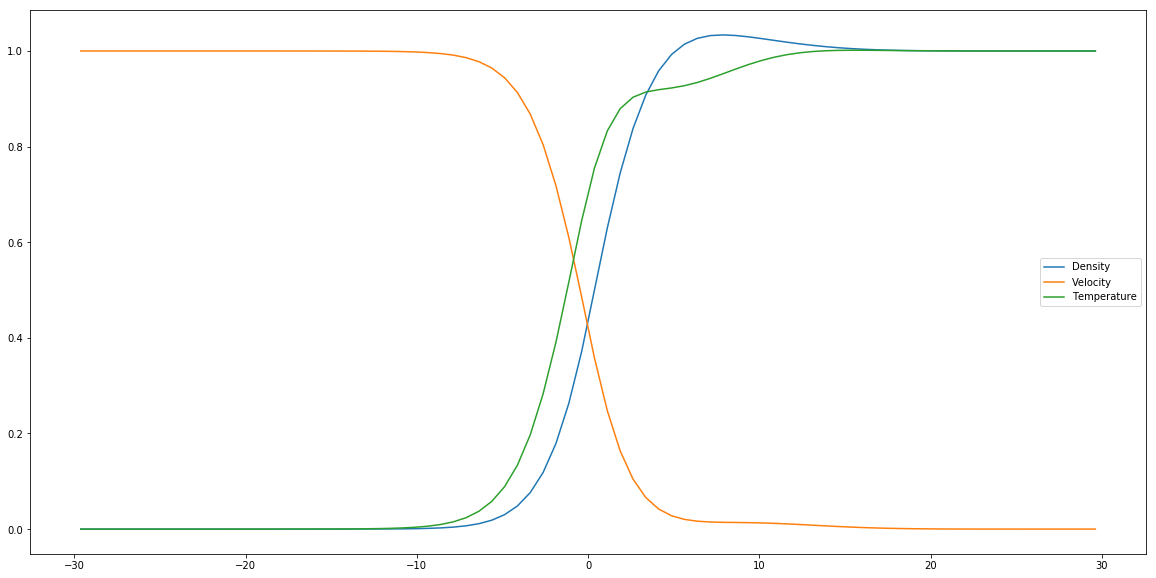

In [44]:
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot(mesh.cell_center_coo[:, 0] / l, (S.Dens - n_l) / (n_r - n_l))
line.set_label('Density')
line, = ax.plot(mesh.cell_center_coo[:, 0] / l, (S.Vel - u_r) / (u_l - u_r))
line.set_label('Velocity')
line, = ax.plot(mesh.cell_center_coo[:, 0] / l, (S.Temp - T_l) / (T_r - T_l))
line.set_label('Temperature')
ax.legend()
plt.show()

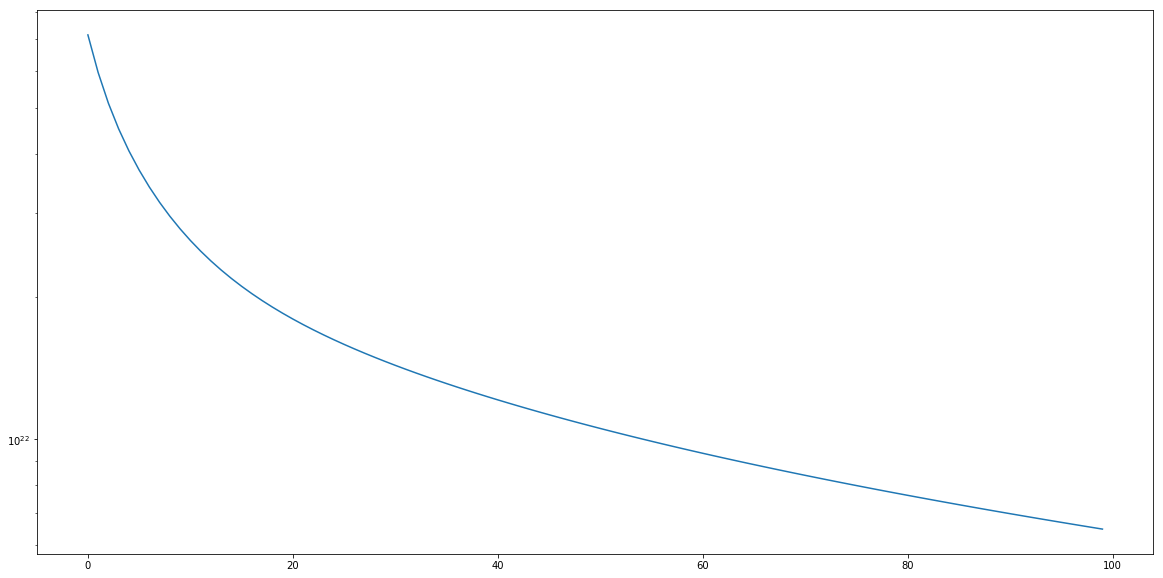

In [45]:
fig, ax = plt.subplots(figsize = (20,10))
plt.semilogy(S.Frob_norm_iter)
plt.show()

In [35]:
v_nil = mesh.face_normals[jf, 0] * vx + mesh.face_normals[jf, 1] * vy + mesh.face_normals[jf, 2] * vz

NameError: name 'jf' is not defined